# Train with the Test split?
This is what we want to do:

1. predict batches with ...
.TODO: create list of content

### 1.) set run-config and hyperparameters

In [1]:
FINAL_SUBMISSION = False # will perform a test on a validation split if set to False

TEST_BATCH_SIZE = 100 # Number of Test entries to add to the training set for the next iteration
ITER_PRINT_EVERY = 1 # Which Iterations to print (every nth)

TRAIN_WITHOUT_HIGHTRUST = False # Set to True to train classifiers only on rows with trustLevel <= 2

# Enable Quick test mode to test functionality on a smaller part of original data or with less iterations etc. than in final version
QUICK_TEST_MODE = True
#TODO!!! Bug: Plot function plot_results_ssl(res) has error sometimes, e.g. for TEST_BATCH_SIZE=250 and QUICK_TEST_MODE_TEST_SIZE = 1000 or 251. I think it might be when QUICK_TEST_MODE_TEST_SIZE is a multiple of TEST_BATCH_SIZE or if nr. iterations is pretty small
QUICK_TEST_MODE_TEST_SIZE = 4000 #set this to the number of test samples you want to use
#TODO lower other hyperparams as well?

In [2]:
# TODO: double check which functions we actually need and only import them / copy them into this.
%run utils.ipynb

### 2.) import python modules

In [3]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors, KDTree
import time
import warnings
warnings.filterwarnings("ignore")

### 3.) define helper functions

In [4]:
def calc_scores(y_test, y_pred):
    y_test_tmp = y_test.copy()
    accuracy = metrics.accuracy_score(y_test_tmp, y_pred)
    confusion_matrix = (metrics.confusion_matrix(y_test_tmp, y_pred)).tolist()
    dmc_score = np.sum(confusion_matrix * np.array([[0, -25], [-5, 5]]))
    return accuracy, dmc_score, confusion_matrix

def get_classifier(name):
    """
    Old: 
    XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, disable_default_eval_metric=1,eval_metric='aucpr',
                gamma=1.8285912697052542, reg_lambda=0.4149772770711012,
                max_bin=254, max_delta_step=7.2556696256684035,
                max_depth=3, min_child_weight=1.0317712458399741, missing=None,
                n_estimators=445, n_jobs=-1, objective='binary:logistic', random_state=0, reg_alpha=0,
                scale_pos_weight=1,silent=True,
                subsample=1, tree_method='gpu_hist', verbosity=2, seed=42)
    NEW: 
    XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, disable_default_eval_metric=1,
       eval_metric='aucpr', gamma=0.8785511762914533,
       learnin_rate=0.6349847443673119, learning_rate=0.1,
       max_delta_step=8.564303568772093, max_depth=3,
       min_child_weight=1.3399467345621474, missing=None, n_estimators=448,
       n_gpus=1, n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=0.16733567917931627,
       scale_pos_weight=1, seed=None, silent=True, subsample=1,
       tree_method='gpu_hist', verbosity=2)
    """
    return {
            'xgb': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                       colsample_bytree=1, disable_default_eval_metric=1,
                       eval_metric='aucpr', gamma=0.8785511762914533,
                       learnin_rate=0.6349847443673119, learning_rate=0.05,
                       max_delta_step=8.564303568772093, max_depth=3,
                       min_child_weight=1.3399467345621474, n_estimators=448,
                       n_gpus=1, n_jobs=1,  objective='binary:logistic',
                       random_state=42, reg_alpha=0, reg_lambda=0.16733567917931627,
                       scale_pos_weight=1, silent=True, subsample=1,
                       tree_method='gpu_hist', verbosity=2)
                if not TRAIN_WITHOUT_HIGHTRUST else 
                    XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                       colsample_bytree=1, disable_default_eval_metric=1,
                       eval_metric='aucpr', gamma=0.5361394269637965,
                       learning_rate=0.05,
                       max_delta_step=2.809035999095031, max_depth=2,
                       min_child_weight=0.9672585190973582, missing=None, n_estimators=403,
                       n_gpus=1, n_jobs=1, nthread=None, objective='binary:logistic',
                       random_state=0, reg_alpha=0, reg_lambda=0.16439595189061076,
                       scale_pos_weight=1, seed=None, silent=True, subsample=1,
                       tree_method='gpu_hist', verbosity=2),
            'svc': SVC(C=11.439334564226868, cache_size=8000, class_weight=None, coef0=0.0,
                        decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
                        kernel='linear', max_iter=-1, probability=True, random_state=42,
                        shrinking=False, tol=0.08370638742373739, verbose=0)
                if not TRAIN_WITHOUT_HIGHTRUST else 
                    #TODO: insert hyperparams for lowtrust-only-training here:
                    SVC(C=5.675273359994213, cache_size=8000, class_weight=None, coef0=0.0,
                        decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
                        kernel='linear', max_iter=-1, probability=True, random_state=42,
                        shrinking=False, tol=0.07958926694361011, verbose=0)


        
    }[name]


### 4.) Import Data

In [5]:
train_Xy_original_df = pd.read_csv("../data/train.csv", sep="|") if FINAL_SUBMISSION else pd.read_csv("../data/train_new.csv", sep="|")
test_X_original_df  = pd.read_csv("../data/test.csv", sep="|", nrows=None if not QUICK_TEST_MODE else QUICK_TEST_MODE_TEST_SIZE) # For faster testing we can use less data from the test set

#Only for test routines
val_Xy_original_df = pd.read_csv("../data/val_new.csv", sep="|")
train_complete_Xy_original_df = pd.read_csv("../data/train.csv", sep="|")
test_final_X_df = pd.read_csv("../data/test.csv", sep="|")


### 5.) Prepare Input X and Label Y Data

In [6]:
#convention for variables names: datasetname_columntype_transformstatus_dataframeornot
train_y_original_df = train_Xy_original_df[["fraud"]].copy()
train_X_original_df = train_Xy_original_df.copy().drop("fraud", axis=1)


# Only for test routie#nes
val_y_originial_df = val_Xy_original_df[["fraud"]].copy()
val_X_originial_df = val_Xy_original_df.copy().drop("fraud", axis=1)

train_complete_y_originial_df = train_complete_Xy_original_df[["fraud"]].copy()
train_complete_X_originial_df = train_complete_Xy_original_df.copy().drop("fraud", axis=1)

### 6.) Data Transformation and data transformation

In [7]:
scaler = StandardScaler()
transformer = DataTransformer(scaler)

if not TRAIN_WITHOUT_HIGHTRUST:
    train_lowtrust_X_original_df = transformer.remove_high_trust(train_X_original_df)

# Adding new Features to train and test set
train_X_unscaled_df = transformer.add_features(train_X_original_df if not TRAIN_WITHOUT_HIGHTRUST else train_lowtrust_X_original_df)
test_X_unscaled_df = transformer.add_features(test_X_original_df)

val_X_unscaled_df = transformer.add_features(val_X_originial_df)
train_complete_X_unscaled_df = transformer.add_features(train_complete_X_originial_df) 

transformer.fit_scaler(transformer.add_features(train_complete_X_unscaled_df.append(test_X_unscaled_df, sort=False)))
train_X_scaled_df = transformer.apply_scaler(train_X_unscaled_df)

test_X_scaled_df  = transformer.apply_scaler(test_X_unscaled_df)
val_X_scaled_df = transformer.apply_scaler(val_X_unscaled_df)
train_complete_X_scaled_df = transformer.apply_scaler(train_complete_X_unscaled_df)


# labels
# TODO: this seems redundant^^

train_y_df = train_y_original_df.copy()
val_y_df = val_y_originial_df.copy()
train_complete_y_df = train_complete_y_originial_df.copy()

test_final_X_df = transformer.add_features(test_final_X_df)


test_X_scaled_df.head(2)

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,totalScannedLineItems
0,0.317174,-0.857599,1.329772,-0.418354,0.959638,0.869131,-0.085073,-0.021819,-0.110333,-0.98995
1,-0.276669,0.157498,0.306417,0.451036,0.324238,-0.884543,-0.068487,-0.094210,-0.352573,1.33811


| Name     | New Features | Scaled |
|----------|--------------|--------|
| orig     |      [ ]     |   [ ]  |
| unscaled |      [X]     |   [ ]  |
| scaled   |      [X]     |   [X]  |

In [8]:
def classify_with_shallow_nn(xgboost_fitted, linear_svc_fitted, data_to_predict, transformer, model):
    prediction = []
    data_to_predict_scaled = transformer.apply_scaler(data_to_predict.copy().reset_index(drop=True))
    data_to_predict_unscaled = data_to_predict.copy().reset_index(drop=True)
    
    threshhold = 25/35    
    for i, row in data_to_predict_unscaled.iterrows():
        
        if row.trustLevel >= 3:
            prediction.append(0)

        else:
            xgb_pred = xgboost_fitted.predict([data_to_predict_unscaled.iloc[i].values])[0]
            xgb_prob = max(np.ravel(xgboost_fitted.predict_proba([data_to_predict_unscaled.iloc[i].values])))
            #print("XGB Prob: ", xgb_prob)
            lsvc_pred = linear_svc_fitted.predict([data_to_predict_scaled.iloc[i]])[0]
            lsvc_prob = max(np.ravel(linear_svc_fitted.predict_proba([data_to_predict_scaled.iloc[i].values])))
            #print("LinSVC Prob: ", lsvc_prob)
            
            res = np.ravel(model.predict(np.array([lsvc_pred,lsvc_prob,xgb_pred,xgb_prob]).reshape((1, -1))))[0]
            prediction.append(1 if res > 0.5 else 0)
    return pd.DataFrame({"fraud": prediction})

In [9]:
def classify_cv(xgboost_fitted, linear_svc_fitted, data_to_predict, transformer, model):
    prediction = []
    data_to_predict_scaled = transformer.apply_scaler(data_to_predict.copy().reset_index(drop=True))
    data_to_predict_unscaled = data_to_predict.copy().reset_index(drop=True)
    
    threshhold = 25/35    
    for i, row in data_to_predict_unscaled.iterrows():
        
        if row.trustLevel >= 3:
            prediction.append(0)

        else:
            xgb_pred = xgboost_fitted.predict([data_to_predict_unscaled.iloc[i].values])[0]
            xgb_prob = max(np.ravel(xgboost_fitted.predict_proba([data_to_predict_unscaled.iloc[i].values])))
            #print("XGB Prob: ", xgb_prob)
            lsvc_pred = linear_svc_fitted.predict([data_to_predict_scaled.iloc[i]])[0]
            lsvc_prob = max(np.ravel(linear_svc_fitted.predict_proba([data_to_predict_scaled.iloc[i].values])))
            #print("LinSVC Prob: ", lsvc_prob)
            
            res = np.ravel(model.predict(np.array([lsvc_pred,lsvc_prob,xgb_pred,xgb_prob]).reshape((1, -1))))[0]
            prediction.append(1 if res > 0.5 else 0)
    return pd.DataFrame(prediction)

In [10]:
def semi_supervised_learning_procedure(test_X_unscaled,train_X_unscaled, train_y, test_data_dict, transformer, model):
    test_data_dict = test_data_dict
    pred_train_dataframes = []
    pred_val_dataframes = []
    results = []
    
    # initialize pseudo labeled train (pltrain) dataset with the transformed training data
    pltrain_X_unscaled_df = train_X_unscaled.copy()
    train_X_scaled_df = transformer.apply_scaler(train_X_unscaled)

    pltrain_X_unscaled_df = test_data_dict['train_X_unscaled_df'].copy()
    pltrain_X_scaled_df = transformer.apply_scaler(pltrain_X_unscaled_df)
    pltrain_y_df = test_data_dict['train_y_df']
    
    
    pltrain_y_df = train_y.copy()
    train_X_scaled_len = len(train_X_unscaled)
    train_X_scaled_len = len(pltrain_X_unscaled_df)
    print("{} available train data before pseudo labeling".format(train_X_scaled_len))

    train_X_scaled_df = transformer.apply_scaler(train_X_unscaled)

    linear_svc_initial = get_classifier('svc')
    linear_svc_initial.fit(train_X_scaled_df.values, pltrain_y_df.values)
    xgboost_initial = get_classifier('xgb')
    xgboost_initial.fit(train_X_unscaled.values, pltrain_y_df.values)
    
   
    print("with a batchsize of ",TEST_BATCH_SIZE, "we will need", len(test_X_unscaled)/TEST_BATCH_SIZE, "iterations:")
    for i in range(TEST_BATCH_SIZE, len(test_X_unscaled), TEST_BATCH_SIZE):
        if int(i / TEST_BATCH_SIZE) % ITER_PRINT_EVERY == 0:
            print("iteration", int(i / TEST_BATCH_SIZE), "\t/", int(np.ceil(len(test_X_unscaled) / TEST_BATCH_SIZE)),
                  "with batch from", i - TEST_BATCH_SIZE, "\t to", i, ", training with", len(pltrain_y_df), "samples")
        # get batch from test set
        testbatch_X_df = test_X_unscaled.iloc[i - TEST_BATCH_SIZE:i].copy().reset_index(drop=True)
                

        """
        ----------------------------------------------------NEW PART ------------------------------------------------------------
        """
        
        pltrain_X_unscaled_df, pltrain_y_df = get_extended_pltrain_for_batch_shallow_nn(testbatch_X_df, pltrain_X_unscaled_df,
                                                                             pltrain_y_df, transformer, model)
        pltrain_X_scaled_df = transformer.apply_scaler(pltrain_X_unscaled_df)
        test_data_dict['pltrain_X_unscaled_df'] = pltrain_X_unscaled_df.copy()
        test_data_dict['pltrain_X_scaled_df'] = pltrain_X_scaled_df.copy()
        test_data_dict['pltrain_y_df'] = pltrain_y_df.copy()
        
        
        linear_svc = get_classifier('svc')
        linear_svc.fit(pltrain_X_scaled_df.values, pltrain_y_df.values)
        
        
        xgboost = get_classifier('xgb')
        xgboost.fit(pltrain_X_unscaled_df.values, pltrain_y_df.values)
        
        
        # Only Test from PLTrain without the data from train
        test_data_dict['test_X_unscaled_df'] = pltrain_X_unscaled_df.iloc[train_X_scaled_len:]
        test_data_dict['test_X_scaled_df'] = pltrain_X_scaled_df.iloc[train_X_scaled_len:]
        test_data_dict['test_y_df'] = pltrain_y_df.iloc[train_X_scaled_len:]
        
        
        res, pred_train_df, pred_val_df = test_routine_shallow_nn(test_data_dict, transformer, model)
       
        results.append(res)
        pred_train_dataframes.append(pred_train_df)
        pred_val_dataframes.append(pred_val_df)
        
        # TODO: also output prediction for validation set when trained on full final dataset
        if int(i / TEST_BATCH_SIZE) % ITER_PRINT_EVERY == 0:
            print("No KNN:   XGBoost: PLTrain auf Val: {} --- PLTest auf Train: {} || LinearSVC:  PLTrain auf Val: {} --- PLTest auf Train: {} || Own Classifier:  PLTrain auf Val: {} --- PLTest auf Train: {}".format(
                res['xgboost']['val']['dmc_score'],res['xgboost']['train']['dmc_score'],res['lin_svc']['val']['dmc_score'],res['lin_svc']['train']['dmc_score'],res['own_classifier']['val']['dmc_score'],res['own_classifier']['train']['dmc_score']))
        
    
    xgb_final = get_classifier("xgb")
    lsvc_final = get_classifier("svc")
    
    xgb_final.fit(pltrain_X_unscaled_df.values, pltrain_y_df.values)
    lsvc_final.fit(pltrain_X_scaled_df.values, pltrain_y_df.values)
    final_prediction = classify_with_shallow_nn(xgb_final, lsvc_final, test_final_X_df.iloc[:50000], transformer,model)
    
    
    return results, final_prediction, pred_val_dataframes, pred_val_dataframes

### 6.) iterative model training using pseudo-labeling
predict batches of the test set, add them to the previous training set and use this new training set to predict the next batch.

In [11]:
def get_extended_pltrain_for_batch_shallow_nn(testbatch_X_unscaled_df, pltrain_X_unscaled_df, pltrain_y_df,transformer, model):
    # train a classificator on the pseudo labeled train (pltrain) dataset
    pltrain_X_scaled_df = transformer.apply_scaler(pltrain_X_unscaled_df)
    linear_svc = get_classifier('svc')
    linear_svc.fit(pltrain_X_scaled_df.values, pltrain_y_df.values)

    xgboost = get_classifier('xgb')
    xgboost.fit(pltrain_X_unscaled_df.values, pltrain_y_df.values)

    testbatch_y = classify_with_shallow_nn(xgboost, linear_svc, testbatch_X_unscaled_df, transformer, model)
    
    # add batch to pseudo labeled train (pltrain) dataset. needs to ignore index as ids in test also start with 0
    pltrainnew_X_unscaled_df = pltrain_X_unscaled_df.append(testbatch_X_unscaled_df, ignore_index=True)
    pltrainnew_y_df = pltrain_y_df.append(testbatch_y,
                                          ignore_index=True)  # pltrainnew_Xy_unscaled_df[['fraud']], ignore_index=True)
    return pltrainnew_X_unscaled_df, pltrainnew_y_df

In [12]:
def get_extended_pltrain_for_batch_shallow_nn_cv(testbatch_X_unscaled_df, pltrain_X_unscaled_df, pltrain_y_df,transformer, model):
    # train a classificator on the pseudo labeled train (pltrain) dataset
    pltrain_X_scaled_df = transformer.apply_scaler(pltrain_X_unscaled_df)
    linear_svc = get_classifier('svc')
    linear_svc.fit(pltrain_X_scaled_df.values, pltrain_y_df.values)

    xgboost = get_classifier('xgb')
    xgboost.fit(pltrain_X_unscaled_df.values, pltrain_y_df.values)

    testbatch_y = classify_cv(xgboost, linear_svc, testbatch_X_unscaled_df, transformer, model)
    
    # add batch to pseudo labeled train (pltrain) dataset. needs to ignore index as ids in test also start with 0
    pltrainnew_X_unscaled_df = pltrain_X_unscaled_df.append(testbatch_X_unscaled_df, ignore_index=True)
    pltrainnew_y_df = pltrain_y_df.append(testbatch_y,
                                          ignore_index=True)  # pltrainnew_Xy_unscaled_df[['fraud']], ignore_index=True)
    return pltrainnew_X_unscaled_df, pltrainnew_y_df

In [13]:
train_Xy_for_crossval = train_complete_X_unscaled_df.copy()
train_Xy_for_crossval['fraud'] = train_complete_y_df.copy()


In [14]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
keras_model = None
with open('../data/model_architecture_all.json', 'r') as f:
    keras_model = model_from_json(f.read())
    
keras_model.load_weights("../data/nn_weights_all.hdf5")

Instructions for updating:
Colocations handled automatically by placer.


In [15]:
data_dict = dict()
data_dict['train_complete_X_unscaled_df'] = train_complete_X_unscaled_df.copy()
data_dict['train_complete_X_scaled_df'] = transformer.apply_scaler(train_complete_X_unscaled_df)
data_dict['train_complete_y_df'] = train_complete_y_df.copy()

data_dict['val_X_unscaled_df'] = val_X_unscaled_df.copy()
data_dict['val_X_scaled_df'] = transformer.apply_scaler(val_X_unscaled_df)
data_dict['val_y_df'] = val_y_df.copy()
data_dict['train_X_unscaled_df'] = train_X_unscaled_df
data_dict['train_X_scaled_df'] = train_X_scaled_df
data_dict['train_y_df'] = train_y_df


# results, final_prediction, knn_dataframes, pred_dfs, pred_val_dfs, results_wo_knn, final_prediction_wo_knn,  pred_train_wo_knn_dfs, pred_val_wo_knn_dfs
results, final_prediction,  pred_train_dfs, pred_val_dfs= semi_supervised_learning_procedure(test_X_unscaled_df, train_X_unscaled_df, train_y_df, data_dict, transformer, keras_model)

1503 available train data before pseudo labeling
with a batchsize of  100 we will need 40.0 iterations:
iteration 1 	/ 40 with batch from 0 	 to 100 , training with 1503 samples


KeyboardInterrupt: 

In [21]:
final_prediction.describe()

NameError: name 'final_prediction' is not defined

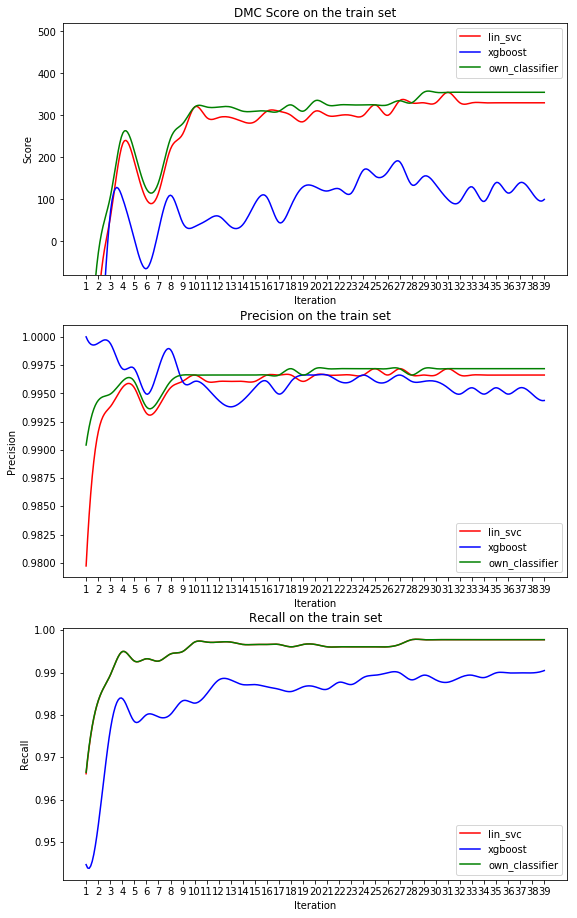

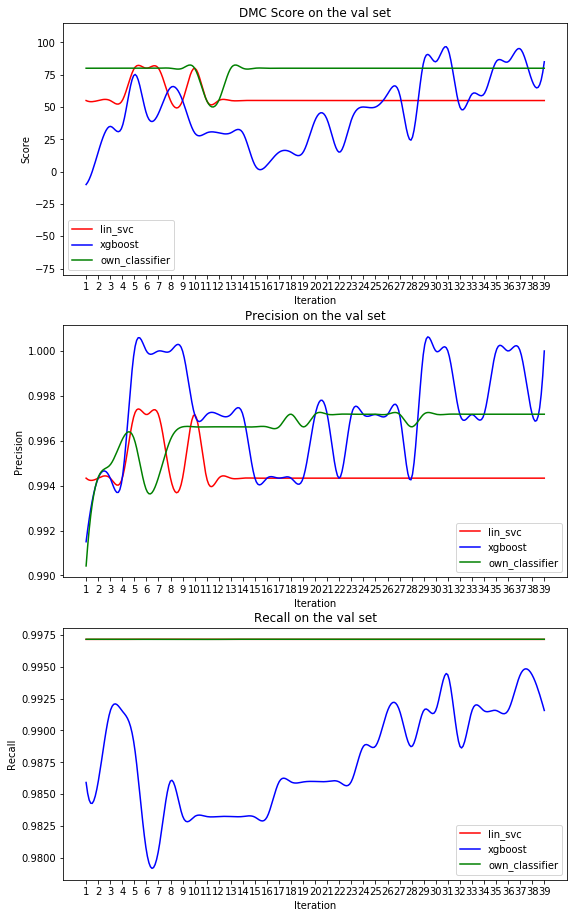

In [19]:
plot_results_ssl(results)

In [20]:
val = pred_val_dfs[0]
val[val.fraud != val.own_predict]

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,totalScannedLineItems,fraud,xgb_predict,lsvc_predict,xgb_proba,lsvc_proba,own_predict
134,1,872,41.86,3,10,4,0.025229,0.048005,0.136364,22.0,0,1,1,0.636,0.553,1
312,2,1461,39.82,6,9,1,0.017112,0.027255,0.240000,25.0,1,0,0,0.515,0.658,0


In [21]:
val[val.fraud != val.lsvc_predict]

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,totalScannedLineItems,fraud,xgb_predict,lsvc_predict,xgb_proba,lsvc_proba,own_predict
97,3,1744,78.42,9,8,4,0.017202,0.044966,0.300000,30.0,0,0,1,0.569,0.515,0
134,1,872,41.86,3,10,4,0.025229,0.048005,0.136364,22.0,0,1,1,0.636,0.553,1
312,2,1461,39.82,6,9,1,0.017112,0.027255,0.240000,25.0,1,0,0,0.515,0.658,0


In [22]:
val[val.fraud != val.xgb_predict]

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,totalScannedLineItems,fraud,xgb_predict,lsvc_predict,xgb_proba,lsvc_proba,own_predict
28,1,653,56.89,9,2,2,0.036753,0.087121,0.375000,24.0,0,1,0,0.532,0.560,0
87,1,1486,57.13,4,1,1,0.015478,0.038445,0.173913,23.0,0,1,0,0.663,0.655,0
133,2,1819,60.15,0,7,3,0.016493,0.033068,0.000000,30.0,1,0,1,0.815,0.852,1
134,1,872,41.86,3,10,4,0.025229,0.048005,0.136364,22.0,0,1,1,0.636,0.553,1
176,1,1625,89.93,11,3,0,0.011692,0.055342,0.578947,19.0,1,0,1,0.695,0.513,1
200,1,1538,60.68,8,6,5,0.012354,0.039454,0.421053,19.0,1,0,1,0.586,0.563,1
208,2,1641,51.34,10,6,2,0.015235,0.031286,0.400000,25.0,1,0,1,0.509,0.562,1
312,2,1461,39.82,6,9,1,0.017112,0.027255,0.240000,25.0,1,0,0,0.515,0.658,0


In [ ]:
val2 = pred_val_dfs[10]
val2[val2.fraud != val2.own_predict]

In [18]:
train_complete_Xy = train_complete_X_unscaled_df.copy()
train_complete_Xy['fraud'] = train_complete_Xy_original_df.fraud
train_complete_Xy.head(2)

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,totalScannedLineItems,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,29.0,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,14.0,0


## Test Own Classifier

In [20]:
own_classifier_cross_validation(train_complete_Xy, test_X_unscaled_df, 1, 5, transformer,keras_model)

DMC Mean: 64.0 --- DMC Sum: 320


(64.0, 320)

## Find best n testsamples

In [16]:
for i in [100,200,300,400,500,600,700]:
    print("Taking ",i, "testsamples")
    dmc_scores = 0
    dmc_sum = 0
    for j in range(10):
        train_Xy_for_crossval = train_complete_X_unscaled_df.copy()
        train_Xy_for_crossval['fraud'] = train_complete_y_df.copy()
        train_Xy_for_crossval.head()
        test_X_for_crossval = test_X_unscaled_df.copy()
        res = own_classifier_cross_validation(train_Xy_for_crossval,test_X_for_crossval,i,5,transformer, keras_model)
        dmc_scores += res[0]
        dmc_sum += res[1]
    print("Mean of DMC Mean is {} and DMC Sum is {} for {} testsamples".format(dmc_scores/10,dmc_sum/10, i, ))


Taking  100 testsamples
DMC Mean: 52.0 --- DMC Sum: 260
DMC Mean: 64.0 --- DMC Sum: 320
DMC Mean: 69.0 --- DMC Sum: 345
DMC Mean: 64.0 --- DMC Sum: 320
DMC Mean: 60.0 --- DMC Sum: 300
DMC Mean: 66.0 --- DMC Sum: 330
DMC Mean: 62.0 --- DMC Sum: 310
DMC Mean: 64.0 --- DMC Sum: 320
DMC Mean: 67.0 --- DMC Sum: 335
DMC Mean: 64.0 --- DMC Sum: 320
Mean of DMC Mean is 63.2 and DMC Sum is 316.0 for 100 testsamples
Taking  200 testsamples
DMC Mean: 64.0 --- DMC Sum: 320
DMC Mean: 53.0 --- DMC Sum: 265
DMC Mean: 64.0 --- DMC Sum: 320
DMC Mean: 59.0 --- DMC Sum: 295
DMC Mean: 57.0 --- DMC Sum: 285
DMC Mean: 60.0 --- DMC Sum: 300
DMC Mean: 55.0 --- DMC Sum: 275
DMC Mean: 62.0 --- DMC Sum: 310
DMC Mean: 67.0 --- DMC Sum: 335
DMC Mean: 57.0 --- DMC Sum: 285
Mean of DMC Mean is 59.8 and DMC Sum is 299.0 for 200 testsamples
Taking  300 testsamples
DMC Mean: 59.0 --- DMC Sum: 295
DMC Mean: 59.0 --- DMC Sum: 295
DMC Mean: 60.0 --- DMC Sum: 300
DMC Mean: 50.0 --- DMC Sum: 250
DMC Mean: 54.0 --- DMC Sum: 

## Create Traindataset for neural net

In [ ]:
pred_val_set = create_nn_train_data(train_Xy_for_crossval, 5, transformer)
pred_val_set.to_csv("../data/nn_train_data_all.csv", sep="|")

In [ ]:
#TODO: Define train1

"""
prf_own = metrics.precision_recall_fscore_support(train1.fraud, train1.own_predict, beta=0.5172, average='binary')
prf_xgb = metrics.precision_recall_fscore_support(train1.fraud, train1.xgb_predict, beta=0.5172, average='binary')
prf_lsvc = metrics.precision_recall_fscore_support(train1.fraud, train1.lsvc_predict, beta=0.5172, average='binary')
dmc_score_own = np.sum(metrics.confusion_matrix(train1.fraud, train1.own_predict)* np.array([[0, -25], [-5, 5]]))
dmc_score_xgb = np.sum(metrics.confusion_matrix(train1.fraud, train1.xgb_predict)* np.array([[0, -25], [-5, 5]]))
dmc_score_lsvc = np.sum(metrics.confusion_matrix(train1.fraud, train1.lsvc_predict)* np.array([[0, -25], [-5, 5]]))


print("OWN CLASSIFIER: Precision: {} Recall: {} Fbeta: {} DMC: {}".format(prf[0], prf[1], prf[2],dmc_score_own))
print("XGBOOST: Precision: {} Recall: {} Fbeta: {} DMC: {}".format(prf_xgb[0], prf_xgb[1], prf_xgb[2],dmc_score_xgb))
print("LINEAR SVCPrecision: {} Recall: {} Fbeta: {} DMC: {}".format(prf_lsvc[0], prf_lsvc[1], prf_lsvc[2],dmc_score_lsvc))
""";

### 7.) pseudo-label the test set and create new classifier based on this
first we predict the original test data labels using the new extended pltrain from above cell and second we use this test data labels to train a new classifier

### 8.) evaluate our new classifier with the original training set

### 9.) combine the pseudo labeled test set with the original train data to train our final classifier

In [ ]:
#final_clf = ...
#TODO; it would be cool if our classify loop can get a sklearn-like api for fit and predict, but we run out of time.
#      we can instead extract final classification from the existing dataframes

### 10.) predict labels for the test set using our final classifier

In [ ]:
#final_testpred_y_original = final_clf.predict(test_X_scaled_df)

### 11.) generate output file neeeded for submission

In [ ]:
#pd.DataFrame(final_testpred_y_original, columns=["fraud"]).to_csv("HS_Karlsruhe_1.csv", index=False)
#pd.read_csv("HS_Karlsruhe_1.csv").head(5)

### 12.) evaluate our new classifier with the validation set
Now at the very end we can also test our final model on a validation split never used before. just for comparison. 

**For the final submission, the following code should will not be run and the full train (incl. this val split) set will be used above**

In [ ]:
#if not FINAL_SUBMISSION:
#    final_valpred_y_original = final_clf.predict(val_X_scaled_df)
#    print(calc_scores(val_y_original_df.fraud.values, final_valpred_y_original))